In [1]:
#Gradient Boosting Machine
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from time import process_time



start_project=process_time()
#Load data
#Save Pickle
root_path = r'D:\Learn\research\Text_Classification2\data'
pickle_folder = 'Pickles'
pickle_path = root_path + '\\' + pickle_folder 

#DataFrame
path_df = pickle_path +'\\df.pickle'
with open(path_df, 'rb') as data: 
    df = pickle.load(data)

#features_train
path_features_train = pickle_path +'\\features_train.pickle'
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)
    
#labels_train
path_labels_train = pickle_path +'\\labels_train.pickle'
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)
    
#features_test
path_features_test = pickle_path + '\\features_test.pickle'
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)
    
#labels_test
path_labels_test = pickle_path + '\\labels_test.pickle'
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)
    

In [2]:
#Cross-Validation for Hyperparameter tuning
gb_0 = GradientBoostingClassifier(random_state = 8)
print('Parameters currently in use: \n')
pprint(gb_0.get_params())

Parameters currently in use: 

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [3]:
features_train.shape

(2346, 300)

In [4]:
features_test.shape

(415, 300)

In [5]:
labels_test.shape

(415,)

In [6]:
labels_train.shape

(2346,)

In [7]:
#Randomized Search Cross Validation

#n_estimators
n_estimators = [200, 800]

#max_features
max_features = ['auto', 'sqrt']

#max_depth
max_depth = [10,40]
max_depth.append(None)

#min_samples_split
min_samples_split = [10, 30, 50]

#min_samples_leaf
min_samples_leaf = [1,2,4]

#learning rate 
learning_rate = [.1, .5]

#subsample 
subsample = [.5, 1.]

#Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [8]:
#First create the base model to tune
gbc = GradientBoostingClassifier(random_state = 8)

#Definition of random search
random_search = RandomizedSearchCV(estimator = gbc, 
                                   param_distributions = random_grid,
                                   n_iter = 50,
                                   scoring = 'accuracy',
                                   cv = 3,
                                   verbose = 1,
                                   random_state = 8)

#Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 385.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [9]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 800, 'min_samples_split': 30, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.9629156010230179


In [10]:
#Grid Search Cross Validation
#Create the parameter grid based on the results of random search
max_depth = [5,10,15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {'max_depth': max_depth,
              'max_features': max_features,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'subsample': subsample}
#Create a base model
gbc = GradientBoostingClassifier(random_state = 8)

#Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argment)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbc,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = cv_sets,
                           verbose = 1)

#Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 569.8min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samp...
                                                  tol=0.0001,
                                                  validation_fraction=0.1,
                 

In [11]:
print('The best hyperparameters from Grid Search are: ')
print(grid_search.best_params_)
print('')
print('The mean accuracy of a model with these hyperparamerter is: ')
print(grid_search.best_score_)

The best hyperparameters from Grid Search are: 
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparamerter is: 
0.9643010752688171


In [12]:
#Save the model in best_gbc:
best_gbc = grid_search.best_estimator_

In [13]:
best_gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [14]:
#Model fit and performance
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=50,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [15]:
#get prediction
gbc_pred = best_gbc.predict(features_test)

In [16]:
#training accuracy

In [17]:
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

1.0


In [18]:
#test accuracy
print('The test accuracy is: ')
print(accuracy_score(labels_test, gbc_pred))

The test accuracy is: 
0.9614457831325302


In [19]:
#Classification report 
print('Classification report')
print(classification_report(labels_test, gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.95      0.92      0.94        78
           1       0.98      0.94      0.96        53
           2       0.90      0.93      0.92        61
           3       0.99      0.99      0.99        86
           4       0.95      0.97      0.96        62
           5       0.99      1.00      0.99        75

    accuracy                           0.96       415
   macro avg       0.96      0.96      0.96       415
weighted avg       0.96      0.96      0.96       415



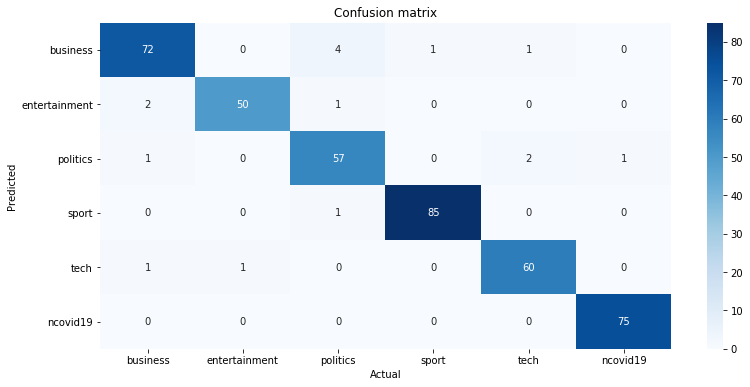

In [20]:
#confusion matrix
aux_df = df [['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot = True,
            xticklabels = aux_df['Category'].values,
            yticklabels = aux_df['Category'].values,
            cmap = 'Blues')

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [21]:
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9518072289156626

In [22]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.9614457831325302

In [23]:
d = {
    'Model': 'Gradient Boosting',
    'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
    'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}
df_models_gbc = pd.DataFrame(d, index = [0])

In [24]:
df_models_gbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,1.0,0.961446


In [25]:
#save model to dataset
model_path = root_path+'\\Models'
with open(model_path+'\\best_gbc.pickle', 'wb') as output:
    pickle.dump(best_gbc, output)
with open(model_path+'\\df_models_gbc.pickle', 'wb') as output:
    pickle.dump(df_models_gbc, output)

In [26]:
end_project = process_time()
print(end_project - start_project, ' seconds')

5294.84375  seconds
